#### Plotting Mutation Prevalence Data

In this example, we will show how to plot the prevalence of a specific mutation from wastewater and clinincal data. Before starting make sure the Python-outbreak-data package is up-to-date and import all necessary plotting and data analysis packages. Here are the ones we used for this plot:

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import matplotlib.dates as mdates

matplotlib.rcParams['hatch.linewidth'] = 0.5
matplotlib.rcParams['font.family'] ='sans-serif'
locator = mdates.MonthLocator(bymonthday=1)


/tmp/ipykernel_942558/3826763493.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Authenticate your credentials in GISAID if you haven't done so yet.

In [2]:
# from outbreak_data import authenticate_user
# authenticate_user.authenticate_new_user()

In [3]:
from outbreak_data import outbreak_data
from outbreak_tools import outbreak_tools
from outbreak_tools import outbreak_clustering

In [4]:
# Saves and plots figure

def plot_out(fname):
    plt.savefig(fname, format='pdf', bbox_inches='tight')
    plt.show();

# Smooths data for plotting - required

def binom_kernel(n, squeeze=0):
    return np.array([scipy.special.binom(n+2*squeeze, x) for x in np.arange(n)+squeeze])
    
smooth = binom_kernel(7*5, 35) # 21

#### Pull wastewater and clinical data

First specify the location and date range for analysis and collect the daily lineage and mutation data from the wastewater samples. Then do the same for the clinical data.

In [5]:
state = "California"
state_id = 'USA_US-CA'
startdate, enddate = "2023-09-02", "2024-01-02"
ww_samples = outbreak_data.get_wastewater_samples(region=state, date_range=[startdate, enddate], server='dev.outbreak.info')
ww_mutations = outbreak_data.get_wastewater_mutations(ww_samples, server='dev.outbreak.info')

Now we'll organize our previously retrieved sample data by date and site_id within our specified region to get the viral load sample data.

#### Prepare mutation data for plotting

The next step is to prepare the mutation data. We specify the mutation we are interested in and then we want to expand and include records for all plausibly scanned mutations. Note the mutation names may be different between wastewater and clinical data.

In [30]:
# counting observed mutations at a specified base pair index:
ww_mutations.loc[ww_mutations['site']==11042, ['alt_base', 'prevalence']].groupby('alt_base').count()

,prevalence
alt_base,
A,1
T,177


In [8]:
mut = '11042T'
ww_mutations4 = outbreak_data.infer_mutations(ww_mutations, [mut])

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/outbreak_data/outbreak_data.py:521: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  mutation_df = mutation_df.set_index(mutation_df['sra_accession'], append=True).unstack(1).stack(dropna=False)
/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/outbreak_data/outbreak_data.py:523: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  mutation_df = mutation_df_b.interpolate().bfill().ffill()


Aggregate daily mutation data for wastewater and clinical data.

In [9]:
ww_muts_daily = outbreak_tools.datebin_and_agg(ww_mutations4, weights=outbreak_tools.get_ww_weights(ww_mutations4), startdate=startdate, enddate=enddate, freq='D', trustna=0.001, log=True, norm=False)
ww_muts_daily_s, ww_muts_daily_vars = outbreak_tools.datebin_and_agg(ww_mutations4, weights=outbreak_tools.get_ww_weights(ww_mutations4), startdate=startdate, enddate=enddate, freq='D', rolling=smooth, trustna=0.001, variance=True, log=True, norm=False)

In [12]:
#Collect and aggregate clinical prevalence data for all lineages with mutation ORF1a:V3593F
cl_mut = outbreak_data.mutation_prevalences(mutations='ORF1a:V3593F', location=state_id, datemin=startdate, datemax=enddate).set_index('query', append=True)
cl_prev_unsmoothed = outbreak_tools.datebin_and_agg(cl_mut.rename(columns={'proportion': 'prevalence'}), norm=False, freq='D', rolling=1)
cl_prev, cl_var = outbreak_tools.datebin_and_agg(cl_mut.rename(columns={'proportion': 'prevalence'}), norm=False, freq='D', rolling=smooth, variance=True)

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/outbreak_data/outbreak_data.py:27: UserWarning: without the lineage_key parameter, descendant queries on aliased lineages with aliased children (eg JN.1 and KP.1) will not be accurate.
  if not lineage_key: warnings.warn('without the lineage_key parameter, descendant queries on aliased lineages with aliased children (eg JN.1 and KP.1) will not be accurate.')


#### wastewater plots

Finally we normalize and plot the prevalence data for both wastewater and clinical datasets and plot the data.

In [13]:
# Normalize the data - required 

def lognorm_ci(x, r):
    return (np.exp(np.log(x)-(r**0.5/x)), np.exp(np.log(x)+(r**0.5/x)))

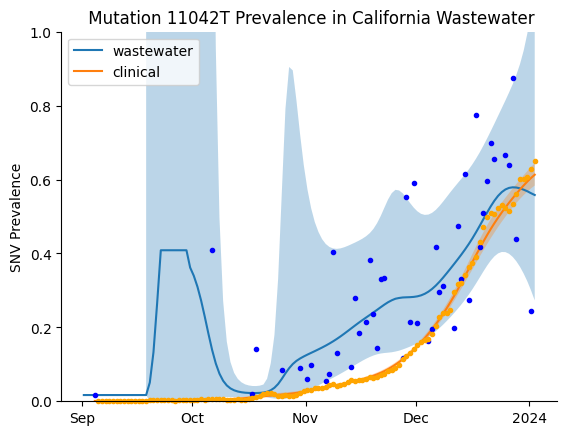

In [14]:
_,ax = plt.subplots()

l,u = lognorm_ci(ww_muts_daily_s, ww_muts_daily_vars)
ax.plot(ww_muts_daily_s[mut].index.mid, ww_muts_daily_s[mut], label = 'wastewater')
ax.fill_between(ww_muts_daily_s[mut].index.mid, l[mut], u[mut], alpha=0.3, zorder=-1)


l,u = lognorm_ci(cl_prev, cl_var)
ax.plot(cl_prev.index.mid, cl_prev, label = 'clinical')
ax.fill_between(cl_var.index.mid, l.iloc[:,0], u.iloc[:,0], alpha=0.3, zorder=-1)

ax.plot(ww_muts_daily.index.mid,ww_muts_daily[mut],'.',color='blue',clip_on=False)
ax.plot(cl_prev_unsmoothed.index.mid,cl_prev_unsmoothed,'.',color='orange',clip_on=False)

ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

ax.set_ylim([0,1.0])
ax.set_title(f' Mutation {mut} Prevalence in {state} Wastewater')
ax.set_ylabel('SNV Prevalence')

plt.legend()
plot_out('mut_prev_ww.pdf')